### 本コードで実施していること

- 株価データの取得
- 前処理
- 特徴量エンジニアリング
- CSVファイルの生成

#### 本コードで使用するライブラリのインストール

In [29]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from statsmodels.tsa.seasonal import STL

### 株価データの取得
使用する株価データ:  
[任天堂(7974)](https://www.nintendo.co.jp/corporate/outline/index.html)

データ取得先:  
[stooq](https://stooq.com/)  

取得期間:  
2000/01/01 ~ 2023/12/31

In [ ]:
# 取得する株価データの範囲を指定
start = '2010-01-01'
end = '2023-12-31'

df = data.DataReader('7974.JP', 'stooq', start, end)

In [20]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-29,7199.0,7395.0,7187.0,7359.0,6355400
2023-12-28,7095.0,7187.0,7081.0,7133.0,3074400
2023-12-27,7000.0,7133.0,6988.0,7126.0,3942400
2023-12-26,6960.0,6987.0,6944.0,6987.0,2087000
2023-12-25,6984.0,7013.0,6911.0,6934.0,1675300


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4582 entries, 2023-12-29 to 2005-03-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4582 non-null   float64
 1   High    4582 non-null   float64
 2   Low     4582 non-null   float64
 3   Close   4582 non-null   float64
 4   Volume  4582 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 214.8 KB


In [22]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


グラフによる終値(`Close`)の可視化

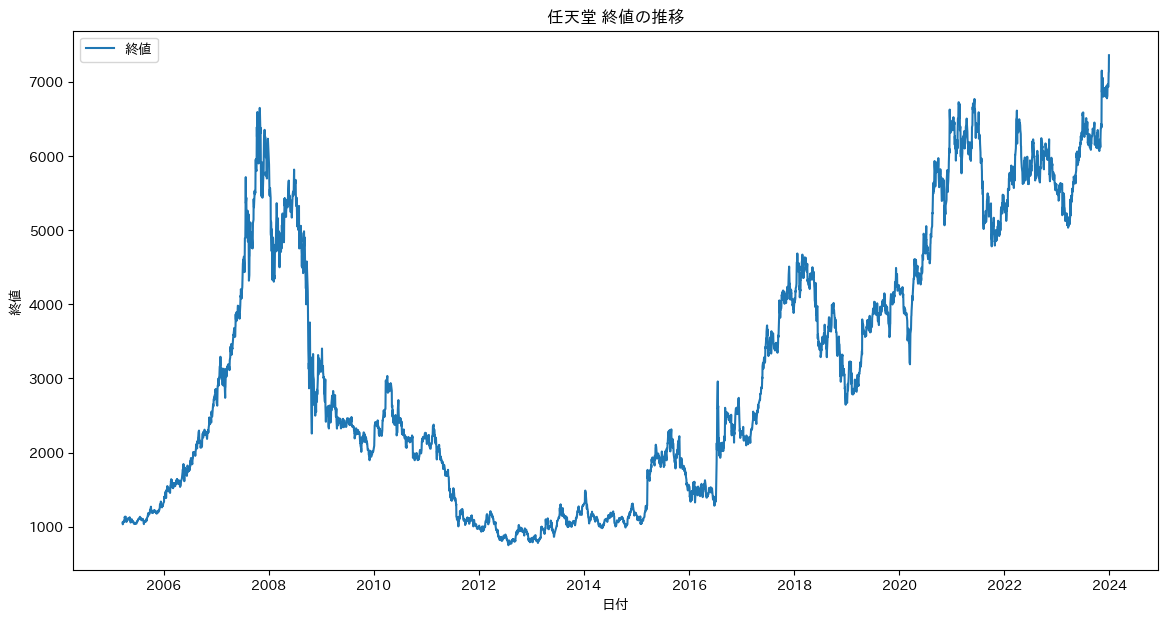

In [36]:
# 終値の折れ線グラフを作成
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='終値')
plt.title('任天堂 終値の推移')
plt.xlabel('日付')
plt.ylabel('終値')
plt.legend()
plt.show()

STL分解

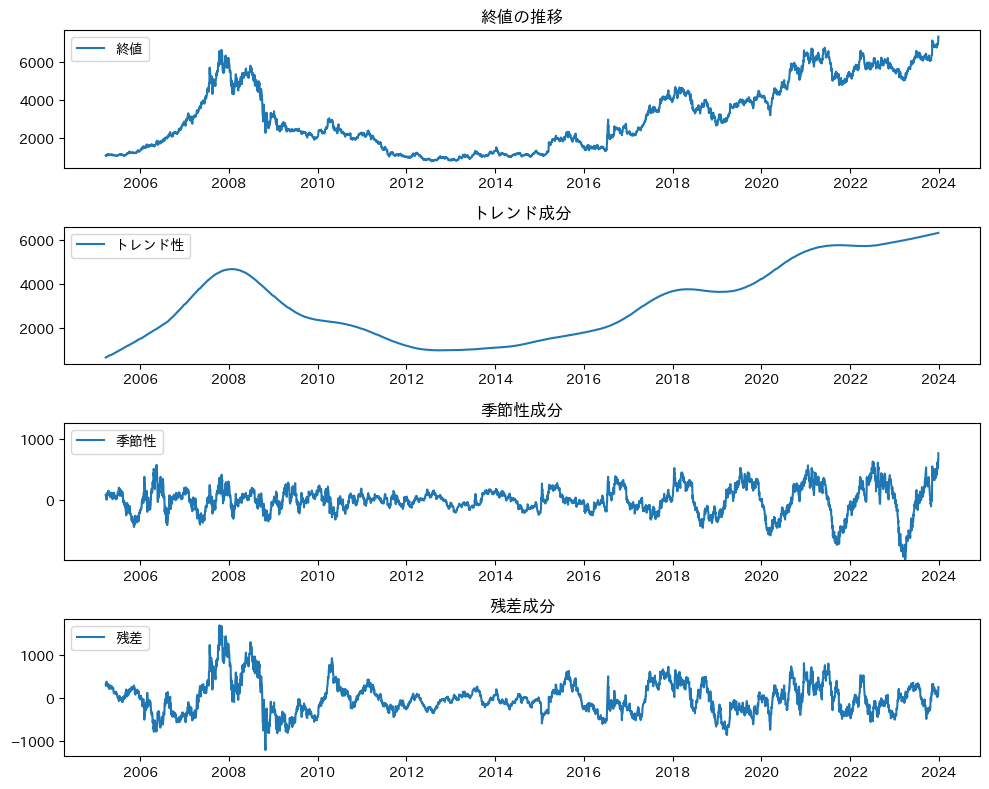

In [43]:
# STL分解の実行
stl = STL(df['Close'], period=365)
result = stl.fit()

# 分解された成分の取得
trend = result.trend
seasonal = result.seasonal
resid = result.resid

# 結果の可視化
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df.index, df['Close'], label='終値')
plt.legend(loc='best')
plt.title('終値の推移')
plt.subplot(412)
plt.plot(df.index, trend, label='トレンド性')
plt.legend(loc='best')
plt.title('トレンド成分')
plt.subplot(413)
plt.plot(df.index, seasonal, label='季節性')
plt.ylim(seasonal.min(), seasonal.max() + 500)
plt.legend(loc='upper left')
plt.title('季節性成分')
plt.subplot(414)
plt.plot(df.index, resid, label='残差')
plt.legend(loc='upper left')
plt.title('残差成分')
plt.tight_layout()
plt.show()

#### 上記結果から分かること  
- 長期的には構造的な上昇トレンドが支配的
- 季節性の影響は限定的だが、近年その重要性が増している
- 市場の効率性は2008年以降、徐々に改善傾向にあることが示唆される

#### 残差成分を用いた異常値検出

In [41]:
# 残差成分に対して、移動平均と移動標準偏差を計算
window = 100
resid_mean = resid.rolling(window=window).mean()
resid_std = resid.rolling(window=window).std()

# 信頼区間の設定
upper_bound = resid_mean + 3 * resid_std
lower_bound = resid_mean - 3 * resid_std

# 異常値の検出
anomalies = (resid > upper_bound) | (resid < lower_bound)

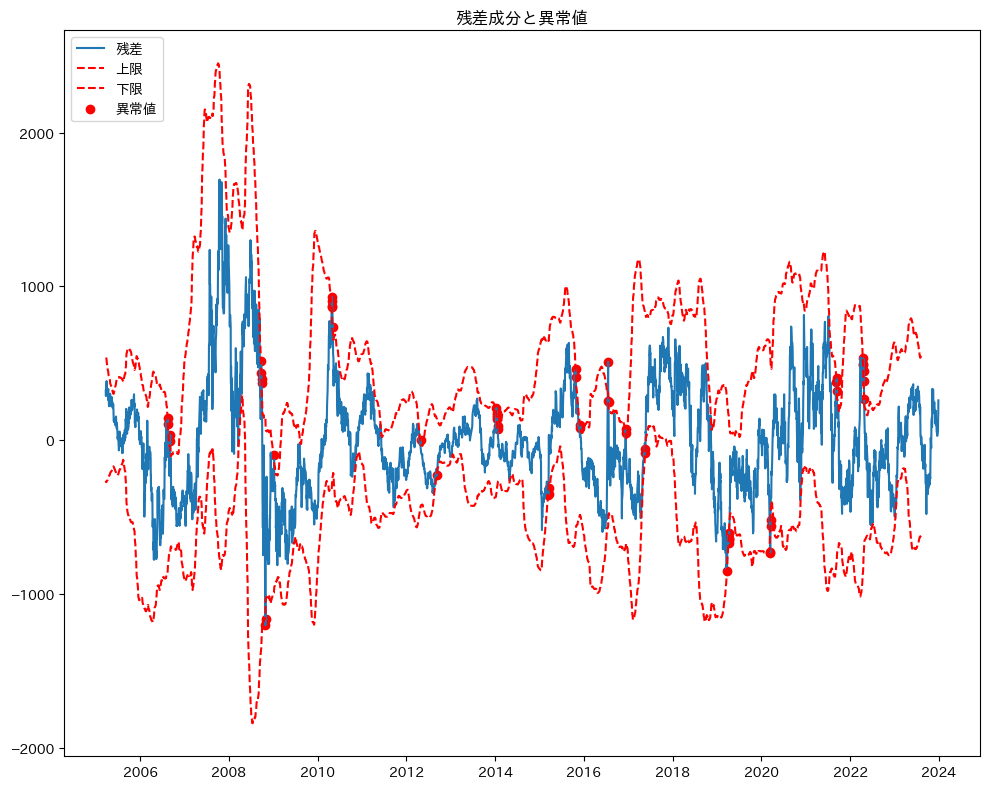

In [45]:
# 結果の可視化
plt.figure(figsize=(10, 8))
plt.plot(df.index, resid, label='残差')
plt.plot(df.index, upper_bound, 'r--', label='上限')
plt.plot(df.index, lower_bound, 'r--', label='下限')
plt.scatter(df.index[anomalies], resid[anomalies], color='red', label='異常値')
plt.legend(loc='upper left')
plt.title('残差成分と異常値')

plt.tight_layout()
plt.show()

### 特徴量エンジニアリング

異常値の検出、および除去

取得したデータのDateカラムのインデックスをリセット、`Date`のデータから新しい変数(`year`、`quarter`、`month`、`week`, `weekofday`, `day`)を作成

In [25]:
df = df.reset_index()

df['year'] = df['Date'].dt.year
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week
df['dayofweek'] = df['Date'].dt.dayofweek
df['day'] = df['Date'].dt.day

上記で作成された変数から、循環性表現するために三角関数を用いて新しい変数を作成

In [26]:
# 月の特徴量の追加
df['month_cos'] = df['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))
df['month_sin'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))

# 週の特徴量の追加
df['week_cos'] = df['week'].apply(lambda x: np.cos(2 * np.pi * x / 52))
df['week_sin'] = df['week'].apply(lambda x: np.sin(2 * np.pi * x / 52))

# 日の特徴量の追加
df['day_cos'] = df['day'].apply(lambda x: np.cos(2 * np.pi * x / 31))
df['day_sin'] = df['day'].apply(lambda x: np.sin(2 * np.pi * x / 31))

`Date`のデータ中央値を基準時点との差分を新たな変数`median_date`として作成

In [28]:
# datetime型のデータの中央値を計算
median_timestamp = df['Date'].astype('int64').median()
median_date = pd.to_datetime(median_timestamp)

start_date = pd.Timestamp(median_date)

df['median_date'] = df['Date'].apply(lambda x: (x - start_date).days)

翌日と当日の終値の差分を計算し、新しい変数`diff_close`を作成

In [ ]:
df_shift = df.shift(-1)
df['diff_close'] = df_shift['Close'] - df['Close']

翌日の終値が当日の終値よりも高ければ1、低ければ0として新しい変数、`increase`を作成

In [9]:
df['increase'] = 0
df['increase'][df['diff_close'] > 0] = 1

/var/folders/ny/dsc26swj73jgprpw8ck05ztw0000gn/T/ipykernel_3222/3138839416.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['increase'][df['diff_close'] > 0] = 1
/var/folders/ny/dsc26swj73jgprpw8ck05ztw0000gn/T/ipykernel_3222/313883941

前日の終値と当日の始値の差分を計算し、新しい変数`diff_close_open`を作成

In [10]:
df_shift_past = df.shift(1)
df['diff_close_open'] =  df_shift_past['終値'] - df['始値']

In [11]:
df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %,year,quarter,month,...,month_cos,month_sin,week_cos,week_sin,day_cos,day_sin,median_date,diff_close,increase,diff_close_open
0,2024-08-01,156.3,159.3,159.4,156.1,79150000.0,-2.56,2024,3,8,...,-0.500000,-0.866025,-0.822984,-0.568065,0.979530,2.012985e-01,6868,4.1,1,NaN
1,2024-07-31,160.4,158.2,160.7,158.1,173910000.0,1.07,2024,3,7,...,-0.866025,-0.500000,-0.822984,-0.568065,1.000000,-2.449294e-16,6867,-1.7,0,-1.9
2,2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63,2024,3,7,...,-0.866025,-0.500000,-0.822984,-0.568065,0.979530,-2.012985e-01,6866,1.0,1,1.6
3,2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14,2024,3,7,...,-0.866025,-0.500000,-0.822984,-0.568065,0.918958,-3.943559e-01,6865,-1.8,0,0.0
4,2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13,2024,3,7,...,-0.866025,-0.500000,-0.885456,-0.464723,0.528964,-8.486443e-01,6862,0.2,1,0.4


当日の始値と終値の差額を追加

In [12]:
df['today_price'] = df['始値'] - df['終値']

三角関数を用いて、時間変数の周期的な構造をエンコード

In [13]:
# 週の特徴量の追加
df['week_cos'] = df['week'].apply(lambda x: np.cos(2 * np.pi * x / 52))
df['week_sin'] = df['week'].apply(lambda x: np.sin(2 * np.pi * x / 52))

# 月の特徴量の追加
df['month_cos'] = df['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))
df['month_sin'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))

# 四半期の特徴量の追加
df['quarter_cos'] = df['quarter'].apply(lambda x: np.cos(2 * np.pi * x / 4))
df['quarter_sin'] = df['quarter'].apply(lambda x: np.sin(2 * np.pi * x / 4))

# 日の特徴量の追加
df['day_cos'] = df['day'].apply(lambda x: np.cos(2 * np.pi * x / 31))
df['day_sin'] = df['day'].apply(lambda x: np.sin(2 * np.pi * x / 31))

欠損値の確認と欠損値を0で補完

In [14]:
# 欠損値の確認と処理
print(df.isnull().sum())
df = df.fillna(0)

日付け                0
終値                 0
始値                 0
高値                 0
安値                 0
出来高                0
変化率 %              0
year               0
quarter            0
month              0
week               0
dayofweek          0
day                0
month_cos          0
month_sin          0
week_cos           0
week_sin           0
day_cos            0
day_sin            0
median_date        0
diff_close         1
increase           0
diff_close_open    1
today_price        0
quarter_cos        0
quarter_sin        0
dtype: int64


CSVファイルの作成

In [15]:
df.to_csv('ml_before.csv', index=False)

最終的に作成された変数

In [16]:
df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %,year,quarter,month,...,week_sin,day_cos,day_sin,median_date,diff_close,increase,diff_close_open,today_price,quarter_cos,quarter_sin
0,2024-08-01,156.3,159.3,159.4,156.1,79150000.0,-2.56,2024,3,8,...,-0.568065,0.979530,2.012985e-01,6868,4.1,1,0.0,3.0,-1.836970e-16,-1.0
1,2024-07-31,160.4,158.2,160.7,158.1,173910000.0,1.07,2024,3,7,...,-0.568065,1.000000,-2.449294e-16,6867,-1.7,0,-1.9,-2.2,-1.836970e-16,-1.0
2,2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63,2024,3,7,...,-0.568065,0.979530,-2.012985e-01,6866,1.0,1,1.6,0.1,-1.836970e-16,-1.0
3,2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14,2024,3,7,...,-0.568065,0.918958,-3.943559e-01,6865,-1.8,0,0.0,-1.0,-1.836970e-16,-1.0
4,2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13,2024,3,7,...,-0.464723,0.528964,-8.486443e-01,6862,0.2,1,0.4,1.4,-1.836970e-16,-1.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   日付け              9202 non-null   datetime64[ns]
 1   終値               9202 non-null   float64       
 2   始値               9202 non-null   float64       
 3   高値               9202 non-null   float64       
 4   安値               9202 non-null   float64       
 5   出来高              9202 non-null   float64       
 6   変化率 %            9202 non-null   float64       
 7   year             9202 non-null   int32         
 8   quarter          9202 non-null   int32         
 9   month            9202 non-null   int32         
 10  week             9202 non-null   UInt32        
 11  dayofweek        9202 non-null   int32         
 12  day              9202 non-null   int32         
 13  month_cos        9202 non-null   float64       
 14  month_sin        9202 non-null   float64